<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARMA</font></b></strong>

**Modelos de Média Móvel Auto-Regressiva (ARMA - Auto Regressive Moving Average)**

O modelo ARMA é simplesmente a fusão entre os modelos AR (p) e MA (q).

Os modelos AR (p) tentam explicar o momento e os efeitos médios da reversão frequentemente observados nos mercados (efeitos dos participantes do mercado).

Os modelos MA (q) tentam capturar os efeitos de choque observados em termos de ruído branco. Estes efeitos de choque podem ser considerados eventos inesperados que afetam o processo de observação, p, como ganhos repentinos, guerras, ataques, etc.

O modelo ARMA tenta capturar esses dois aspectos ao modelar séries temporais. O modelo ARMA não leva em consideração o agrupamento de volatilidade, um fenômeno empírico essencial de muitas séries temporais financeiras que discutiremos mais adiante.

Modelo ARMA(1,1) é representado como:

x(t) = a*x(t-1) + b*e(t-1) + e(t)

Onde e(t) é o ruído branco com E [e(t)] = 0

Um modelo ARMA geralmente requer menos parâmetros que um modelo AR (p) ou um modelo MA (q) individual. Ou seja, é redundante em seus parâmetros.

Criaremos um modelo ARMA neste notebook.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# Instala o plotly
#!pip install -q plotly

In [4]:
# O comando abaixo instala o plotly-orca para gráficos interativos
# Se necessário, reinicie o Jupyter Notebook
# Não funciona no Google Colab, a menos que você instale o mini-conda no Google Colab. Pesquise sobre como fazer isso.
# !conda install -y -c plotly plotly-orca

In [5]:
# O statsmodels deve ser atualizado
#!pip install -q -U statsmodels

In [6]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('ggplot')
%matplotlib inline

## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [7]:
# Carrega os dados
dados = pd.read_csv('data/vendasHistoricas.csv')

In [8]:
# Shape
dados.shape

(9994, 21)

In [9]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [10]:
# Visualizando os dados
dados.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [11]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [12]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [13]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [14]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [15]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [16]:
# Vamos checar os valores únicos por coluna (para ajudar a definir se a variável é categórica ou não)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

ship_mode {'Second Class', 'First Class', 'Standard Class', 'Same Day'}
segment {'Corporate', 'Home Office', 'Consumer'}
country {'United States'}
region {'Central', 'West', 'South', 'East'}
category {'Office Supplies', 'Furniture', 'Technology'}
sub_category {'Furnishings', 'Storage', 'Chairs', 'Paper', 'Envelopes', 'Copiers', 'Fasteners', 'Binders', 'Supplies', 'Phones', 'Bookcases', 'Labels', 'Art', 'Machines', 'Appliances', 'Accessories', 'Tables'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


In [19]:
# Não funciona no Google Colab, a menos que você instale o mini-conda no Google Colab. Pesquise sobre como fazer isso.

# Vamos checar as categorias de itens
#a = dados['category'].value_counts()
#fig = px.bar(a, x = a.index, y = a.values, height = 400)
#fig.update_layout(title = {'text': "Categorias de Itens", 
#                           'y':0.9,'x':0.5,'xanchor': 
#                           'center','yanchor': 'top'},
#                  xaxis_title = "Categoria",
#                  yaxis_title = "Total de Itens")
#fig.show(renderer = 'svg')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [20]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [21]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

In [22]:
# Como está ficando cada dataset?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [23]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')
ts_moveis = ts_moveis.set_index('order_date')
ts_office = ts_office.set_index('order_date')

In [24]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

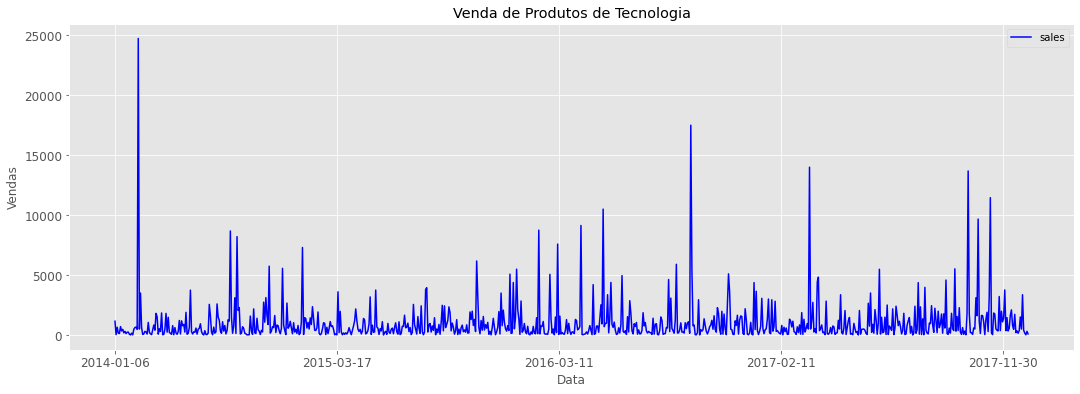

In [25]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

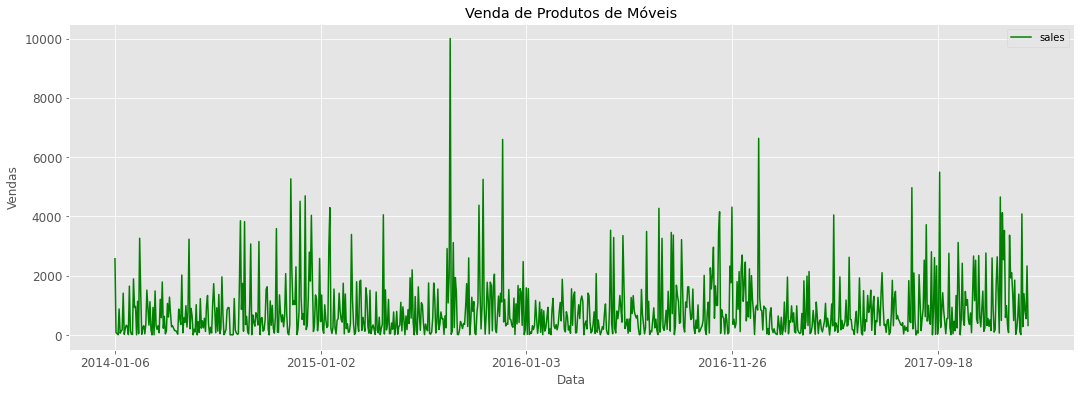

In [26]:
# Venda de Produtos de Móveis
vendas_moveis = ts_moveis[['sales']]
ax = vendas_moveis.plot(color = 'g', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Móveis")
plt.show()

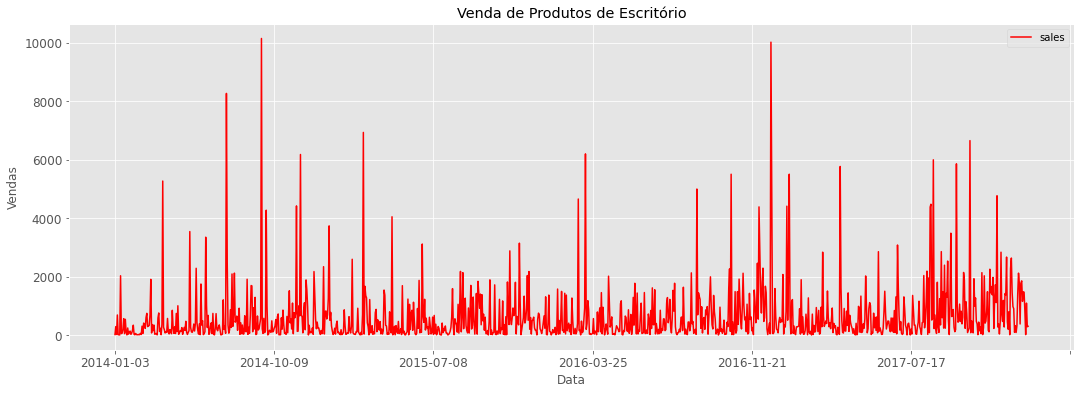

In [27]:
# Venda de Produtos de Escritório
vendas_office = ts_office[['sales']]
ax = vendas_office.plot(color = 'r', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Escritório")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

Entendeu por que o Cientista de Dados deve ser muito bem remunerado? :-)

In [28]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [29]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)
vendas_moveis.index = pd.to_datetime(vendas_moveis.index)
vendas_office.index = pd.to_datetime(vendas_office.index)

In [30]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [31]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()
media_vendas_moveis = vendas_moveis['sales'].resample('MS').mean()
media_vendas_office = vendas_office['sales'].resample('MS').mean()

In [32]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [33]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

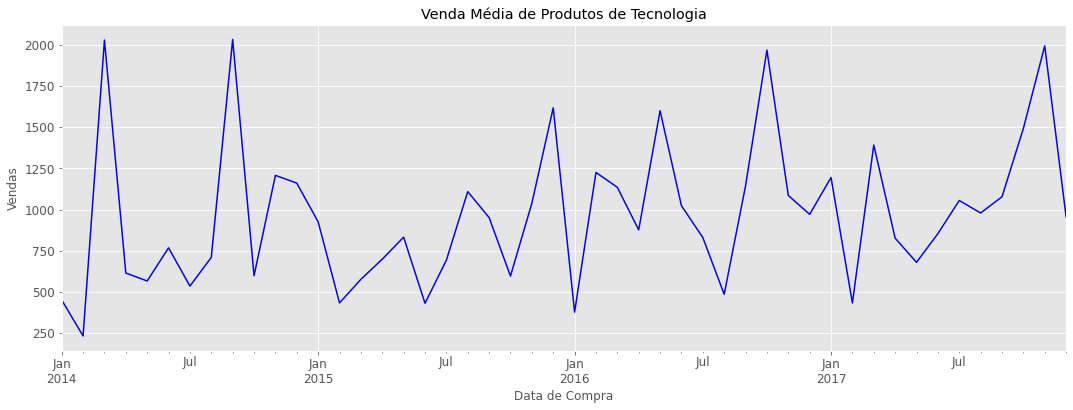

In [38]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

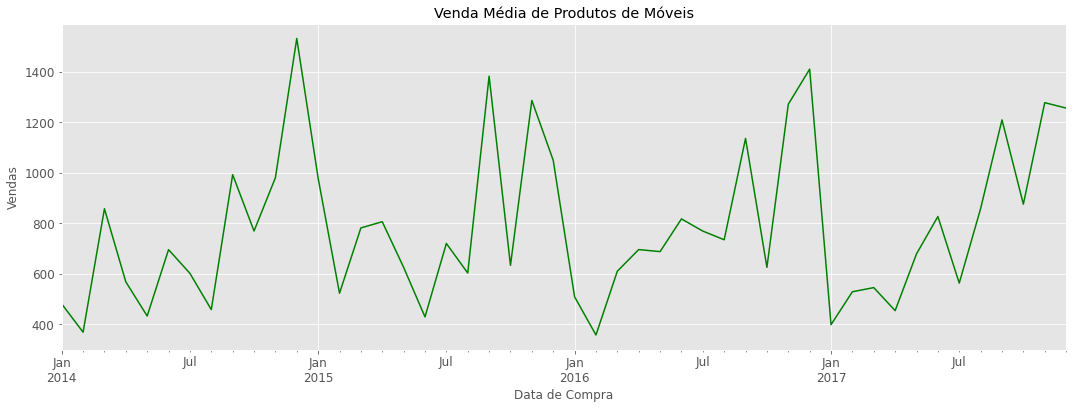

In [39]:
# Venda Média de Produtos de Móveis
media_vendas_moveis.plot(figsize = (18, 6), color = 'green')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Móveis")
plt.show()

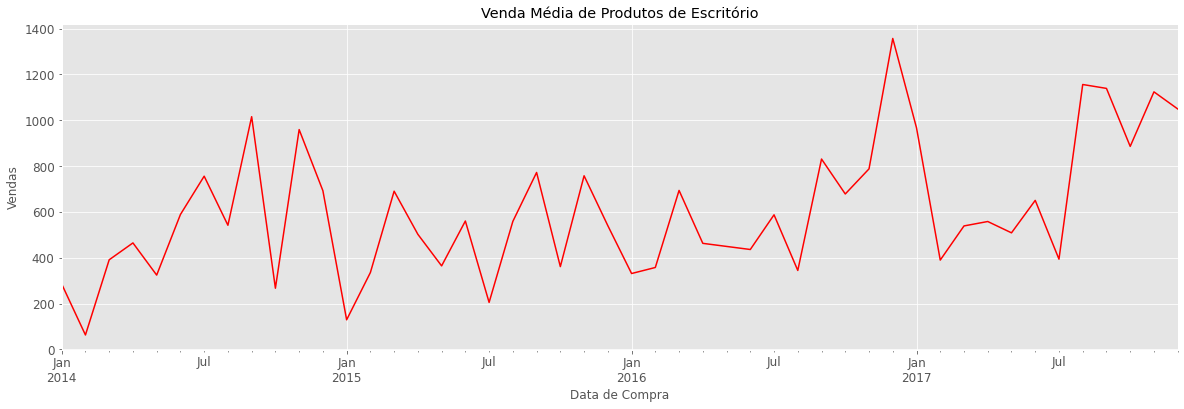

In [40]:
# Venda Média de Produtos de Escritório
media_vendas_office.plot(figsize = (20, 6), color = 'red')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Escritório")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

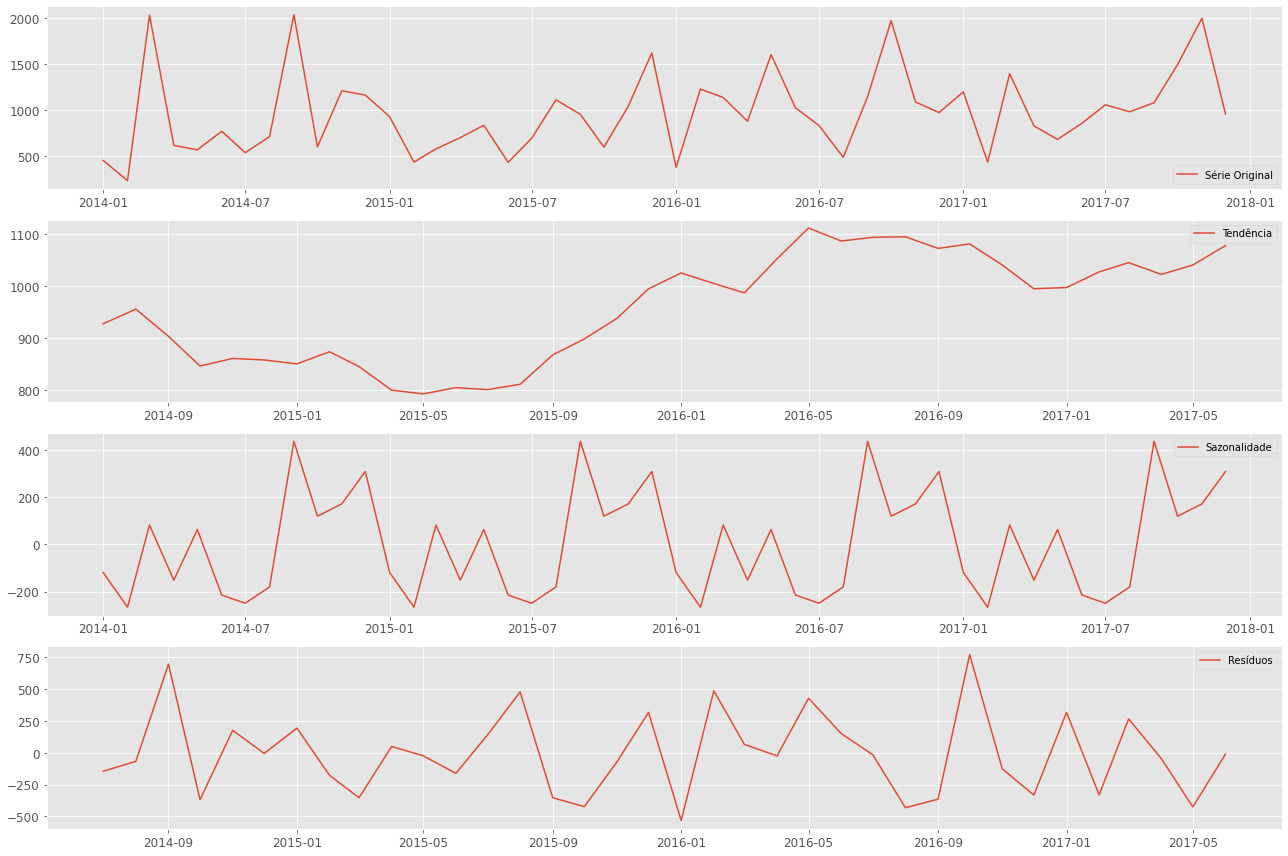

In [41]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, freq = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [42]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

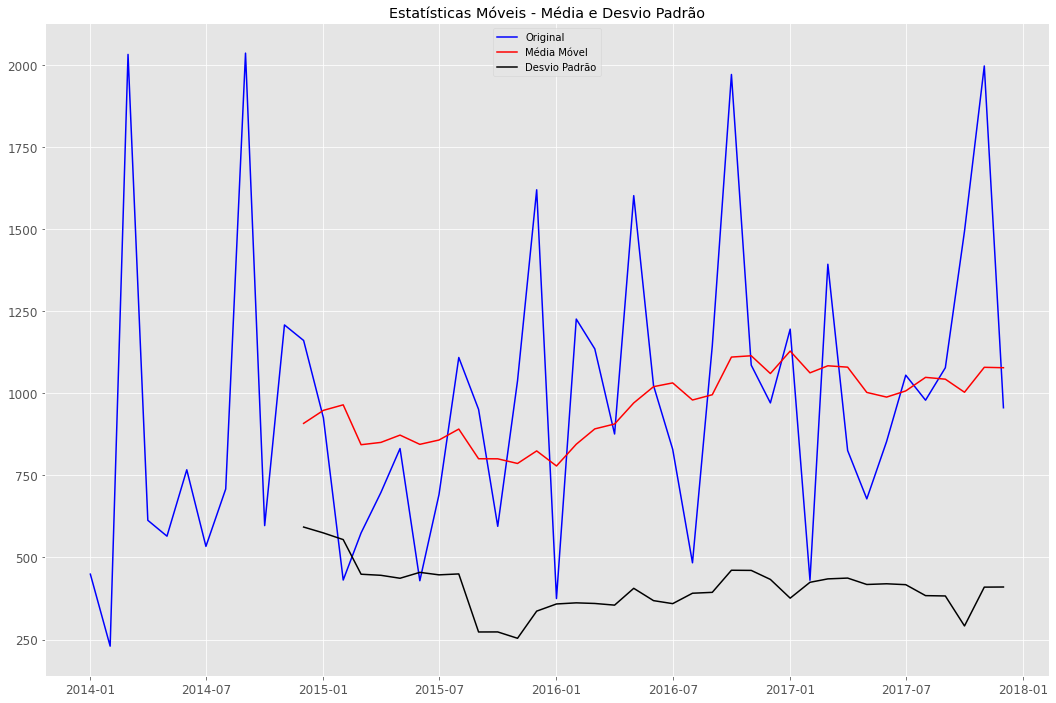


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [43]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [44]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

### Função Para o Cálculo da Acurácia

In [45]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## Modelo ARMA

Dada uma série temporal de dados Xt, o modelo ARMA é uma ferramenta para entender e, talvez, prever valores futuros nesta série. A parte AR envolve a regressão da variável com seus próprios valores defasados (isto é, passados). A parte MA envolve modelar o termo de erro como uma combinação linear de termos de erro que ocorrem contemporaneamente e em vários momentos no passado. O modelo é geralmente chamado de modelo ARMA (p, q), em que p é a ordem da parte AR e q é a ordem da parte MA.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html

In [46]:
# Cria o modelo
modelo_arma = ARMA(trainset, order = (1, 1))

In [47]:
# Treina o modelo
modelo_arma_fit = modelo_arma.fit(method = 'mle', disp = False)

In [48]:
# Sumário do modelo
modelo_arma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  sales   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                -271.129
Method:                           mle   S.D. of innovations            451.224
Date:                Tue, 14 Jun 2022   AIC                            550.257
Time:                        10:58:37   BIC                            556.591
Sample:                    01-01-2014   HQIC                           552.468
                         - 12-01-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         932.6195     59.210     15.751      0.000     816.569    1048.670
ar.L1.sales     0.3312      0.651      0.509      0.611      -0.944       1.607
ma.L1.sales    -0.4805      0.601     -0.799      0.424      -1.659       0.698
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0191           +0.0000j            3.0191            0.0000
MA.1            2.0814           +0.0000j            2.0814            0.0000
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

In [49]:
# Previsões com o modelo
arma_predict = modelo_arma_fit.predict(start = pd.to_datetime('2017-01-01'), 
                                       end = pd.to_datetime('2017-12-01'),
                                       dynamic = False)

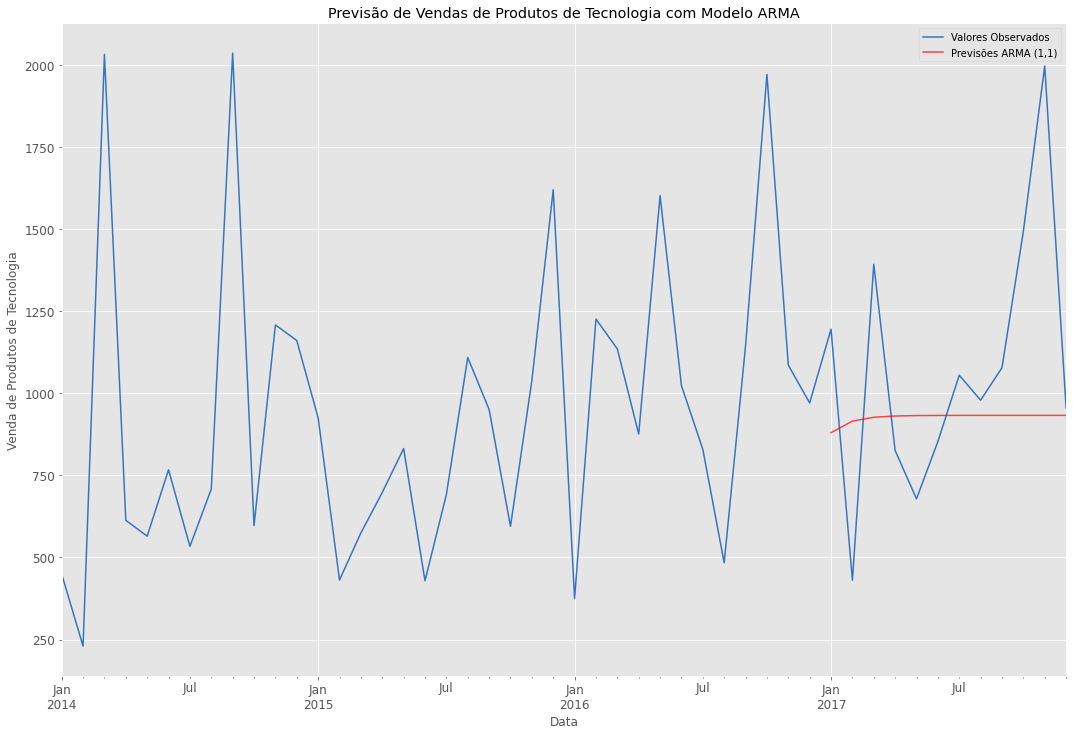

In [50]:
# Vamos fazer previsão de um passo a frente
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#3574BF')
rcParams['figure.figsize'] = 18, 8
arma_predict.plot(ax = ax, label = 'Previsões ARMA (1,1)', alpha = 0.7, color = 'red') 
plt.title('Previsão de Vendas de Produtos de Tecnologia com Modelo ARMA')
plt.xlabel('Data')
plt.ylabel('Venda de Produtos de Tecnologia')
plt.legend()
plt.show()

In [51]:
# Avaliando a performance com dados de teste 
arma_results = performance(testset, arma_predict)
arma_results

MSE das previsões é 176567.83
RMSE das previsões é 420.2
MAPE das previsões é 29.58


Vamos executar alguns diagnósticos para avaliar o modelo.

Começamos criando uma função com os Plots ACF e PACF, além dos resíduos.

In [56]:
# Função
def tsplot(y, lags = None, figsize = (12, 8), style = 'bmh'):
    
    # Se a série não for do tipo pd.Series, fazemos a conversão
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Criamos os plots
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Plots Para Análise de Séries Temporais')
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.05)

        if lags < 18:
            smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.05)
        sm.qqplot(y, line = 's', ax = qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)

        plt.tight_layout()
    return

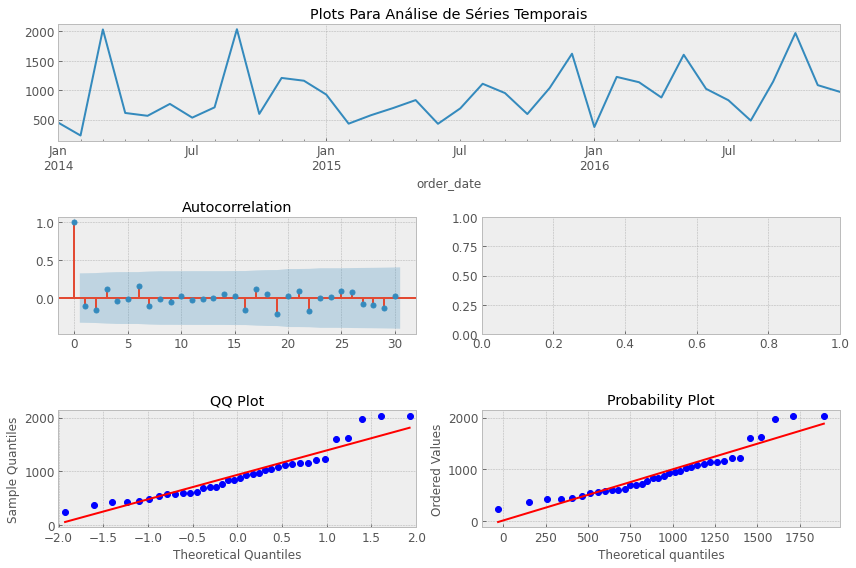

In [57]:
# Executa a função com dados de treino
tsplot(trainset, lags = 30)

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [58]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arma_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\nOs resíduos podem não ser normalmente distribuídos.')
else:
    print ('\nOs resíduos parecem normalmente distribuídos.')


Os resíduos parecem normalmente distribuídos.


In [59]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arma_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.90023432]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, um modelo ARMA (1,1) fornece um bom ajuste do modelo.

---

Agora, uma pergunta para você:

Como decidimos os valores de p e q?

Para ajustar os dados a um modelo ARMA, usamos o Akaike Information Criterion (AIC) em um subconjunto de valores para p, q para encontrar o modelo com o mínimo AIC e, em seguida, aplicamos o teste de Ljung-Box para determinar se um bom ajuste foi alcançado para valores particulares de p, q. Se o valor-p do teste for maior que a significância requerida, podemos concluir que os resíduos são independentes e ruído branco.

In [60]:
# Vamos tentar encontrar os melhores valores de p e q
# O AIC deve ser o menor possível

# Valores iniciais
melhor_aic = np.inf 
melhor_order = None
melhor_modelo = None

# Valores para testar a melhor combinação order = (i, j)
valores_para_order = [1, 2, 3, 4, 5]

# Loop
for i in valores_para_order:
    for j in valores_para_order:
        try:
            tmp_mdl = ARMA(trainset, order = (i, j)).fit(disp = False)
            tmp_aic = tmp_mdl.aic
            if tmp_aic < melhor_aic:
                melhor_aic = tmp_aic
                melhor_order = (i, j)
                melhor_modelo = tmp_mdl
        except: continue

# Print
print('\nMelhor Valor de AIC: %6.2f | order: %s'%(melhor_aic, melhor_order))
print('\nMelhor Modelo:', melhor_modelo.summary())

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Melhor Valor de AIC: 550.26 | order: (1, 1)

Melhor Modelo:                               ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                -271.129
Method:                       css-mle   S.D. of innovations            451.224
Date:                Tue, 14 Jun 2022   AIC                            550.257
Time:                        11:00:56   BIC                            556.591
Sample:                    01-01-2014   HQIC                           552.468
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         932.6156     59.210     15.751      0.000     816.566    1048.666
ar.L1.sales     0.3312      0.651      0.509      0.611      -0.944

As mensagens de warning acima indicam que para algumas combinações de order (i, j) o modelo não consegue nem mesmo convergir. Por fim, a melhor combinação foi a que escolhemos no início e que apresenta a melhor performance: order: (1, 1).

Será que conseguimos fazer melhor do que isso? Você não vi nada ainda! Além do Modelo ARMA, confira os modelos que vamos criar nas próximas aulas:

- Modelo ARIMA
- Modelo SARIMA
- Modelo Triple Exponential Smoothing
- Modelo Prophet
- Modelo LSTM (Deep Learning)
- Modelo Stacked LSTM (Deep Learning)
- Modelo Bidirectional LSTM (Deep Learning)
- Modelo Convolutional Neural Network (Deep Learning)

Estudaremos ainda como usar Grid Search para encontrar os melhores valores dos parâmetros p, d e q